<a href="https://colab.research.google.com/github/ThienNguyen3001/Stock-Price-Prediction-LSTM-RNN/blob/main/stock_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
%%capture
!git clone https://github.com/ThienNguyen3001/Stock-Price-Prediction-LSTM-RNN.git
!rsync -av Stock-Price-Prediction-LSTM-RNN/ ./ --exclude=.git
!pip3 install d2l

In [30]:
import pandas as pd
import numpy as np
from numpy import zeros, newaxis

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from d2l import torch as d2l

from sklearn.preprocessing import MinMaxScaler
import math, time
from math import sqrt
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

import statistics as st
import scipy as sc
from src import *

ModuleNotFoundError: No module named 'src'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suruchiarora/yahoo-finance-dataset-2018-2023")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/suruchiarora/yahoo-finance-dataset-2018-2023/versions/1


In [ ]:
df = pd.read_excel(r'/root/.cache/kagglehub/datasets/suruchiarora/yahoo-finance-dataset-2018-2023/versions/1/yahoo_data.xlsx')
df

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000
...,...,...,...,...,...,...,...
1253,"May 07, 2018",24317.66,24479.45,24263.42,24357.32,24357.32,307670000
1254,"May 04, 2018",23865.22,24333.35,23778.87,24262.51,24262.51,329480000
1255,"May 03, 2018",23836.23,23996.15,23531.31,23930.15,23930.15,389240000
1256,"May 02, 2018",24097.63,24185.52,23886.30,23924.98,23924.98,385350000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1258 non-null   object 
 1   Open         1258 non-null   float64
 2   High         1258 non-null   float64
 3   Low          1258 non-null   float64
 4   Close*       1258 non-null   float64
 5   Adj Close**  1258 non-null   float64
 6   Volume       1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.rename(columns={'Close*': 'Close', 'Adj Close**': 'Adj Close'}, inplace=True)

In [ ]:
df.set_index('Date', inplace = True)

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,29595.823045,29776.945739,29402.432226,29599.361677,29599.361677,3.450636e+08
std,4006.078299,4009.007573,4004.949066,4007.468822,4007.468822,1.069142e+08
min,19028.360000,19121.010000,18213.650000,18591.930000,18591.930000,8.615000e+07
25%,26041.267500,26163.155000,25877.872500,26027.120000,26027.120000,2.773125e+08
50%,29201.410000,29335.685000,28996.500000,29199.460000,29199.460000,3.247250e+08
75%,33604.027500,33825.445000,33346.827500,33600.342500,33600.342500,3.875100e+08
max,36722.600000,36952.650000,36636.000000,36799.650000,36799.650000,9.159900e+08


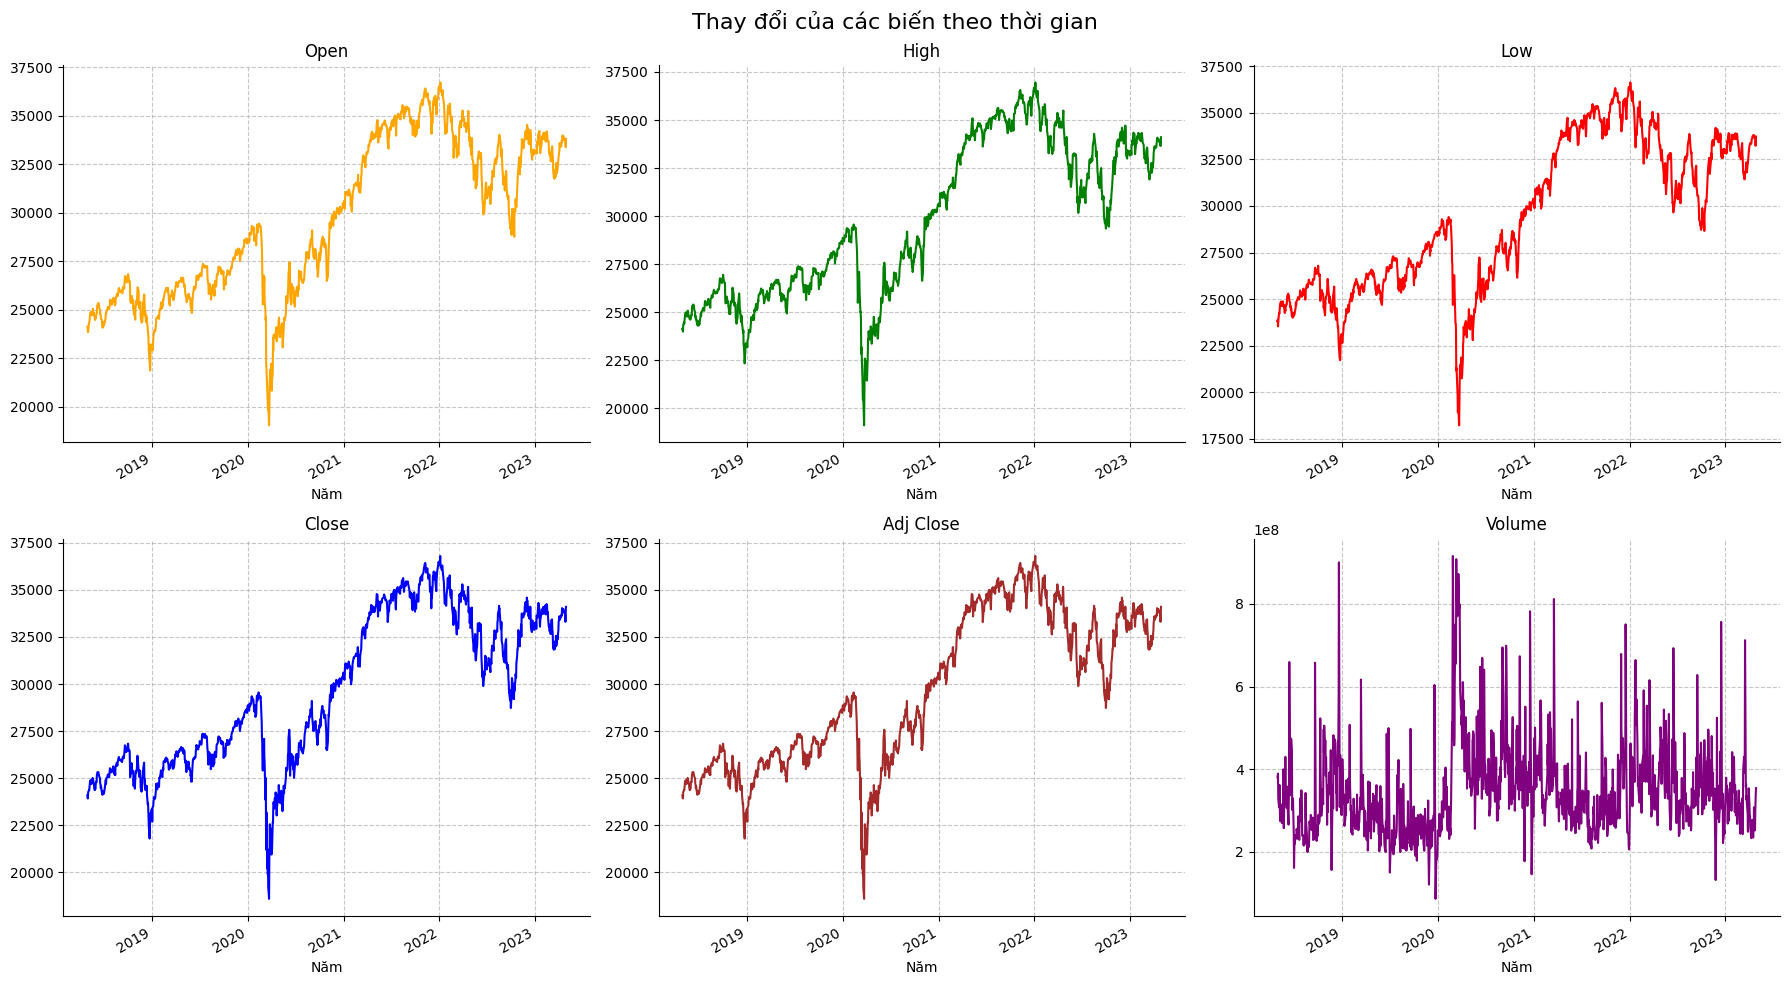

In [ ]:
# Create figure and subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Thay đổi của các biến theo thời gian', fontsize=16)

# Plot price metrics
metrics = {
    (0,0): ('Open', 'orange', 'Open'),
    (0,1): ('High', 'green', 'High'),
    (0,2): ('Low', 'red', 'Low'),
    (1,0): ('Close*', 'blue', 'Close'),
    (1,1): ('Adj Close**', 'brown', 'Adj Close'),
    (1,2): ('Volume', 'purple', 'Volume')
}

# Create each subplot
for (row, col), (metric, color, title) in metrics.items():
    df[metric].plot(ax=axes[row,col], color=color)
    axes[row,col].set_title(title)
    axes[row,col].spines[['top', 'right']].set_visible(False)
    axes[row,col].grid(True, linestyle='--', alpha=0.7)
    axes[row,col].set_xlabel('Năm')

# Adjust layout
plt.tight_layout()
plt.show()

* Tất cả các biểu đồ ngoại trừ "Volume" đều có một dạng tương tự và đó là bởi vì sau giá mở cửa, thị trường chứng khoán thường có một biến động nhỏ lên xuống khiến cho các biểu đồ giá này tuân theo cùng một mô hình nhưng đối với cột "Volume" thì đây là một quá trình khá ngẫu nhiên đối với lượng giao dịch trong một ngày nhất định.

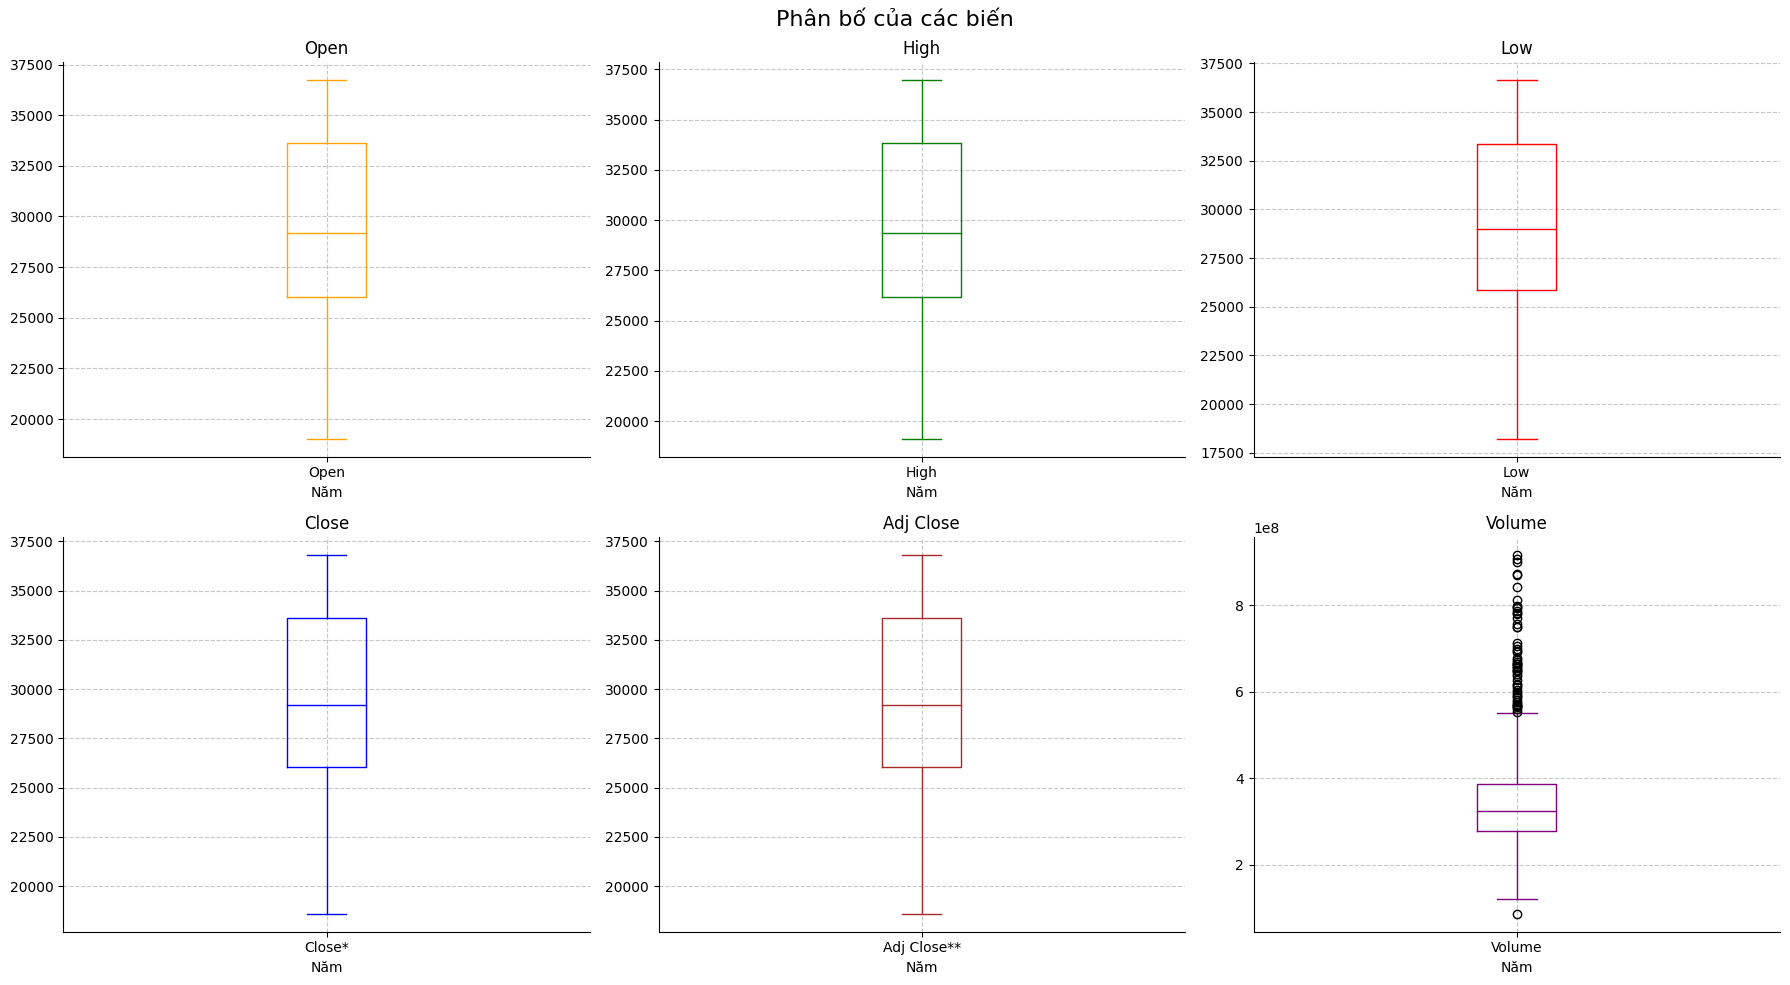

In [ ]:
# Create figure and subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Phân bố của các biến', fontsize=16)

# Plot price metrics
metrics = {
    (0,0): ('Open', 'orange', 'Open'),
    (0,1): ('High', 'green', 'High'),
    (0,2): ('Low', 'red', 'Low'),
    (1,0): ('Close*', 'blue', 'Close'),
    (1,1): ('Adj Close**', 'brown', 'Adj Close'),
    (1,2): ('Volume', 'purple', 'Volume')
}

# Create each subplot
for (row, col), (metric, color, title) in metrics.items():
    df[metric].plot.box(ax=axes[row,col], color=color)
    axes[row,col].set_title(title)
    axes[row,col].spines[['top', 'right']].set_visible(False)
    axes[row,col].grid(True, linestyle='--', alpha=0.7)
    axes[row,col].set_xlabel('Năm')

# Adjust layout
plt.tight_layout()
plt.show()

* Đối với các biến về giá, có thể nhận thấy rằng nhìn chung chúng được phân bổ tốt nhưng biến "Volume" chứa một số giá trị ngoại lệ. Điều này được giải thích bởi thực tế là khi cổ phiếu giao dịch bắt đầu tăng thì giá trị giá giảm xuống, giải thích cho sự sụt giảm đột ngột về giá và "Volume" đạt đỉnh.

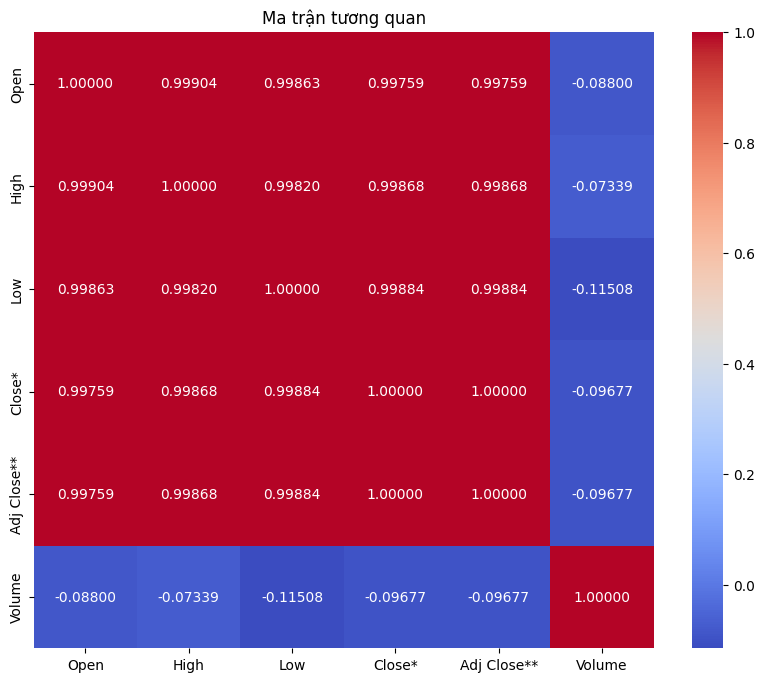

In [ ]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".5f")
plt.title('Ma trận tương quan')
plt.show()

In [ ]:
closing_price = df[['Close']]

window_size = 15 #14 input values and 15th value is the target

In [ ]:
#Function for normalising and splitting data
scaler = MinMaxScaler(feature_range=(-1, 1))

def split_data(prices, window):
    raw = prices.to_numpy()
    data = []
    plotting = []

    #The last 15 indexes will include null values so we subtract the window size
    for index in range(len(raw) - window):
        plotting.append(raw[index][0])
        data.append(raw[index: index + window])

    plotting = pd.DataFrame(plotting)
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    X_train = data[:train_set_size,:-1,]
    X_train = scaler.fit_transform(X_train.reshape(-1,1))
    X_train = X_train.reshape(train_set_size, window - 1, 1)
    y_train = data[:train_set_size,-1,:]
    y_train = scaler.fit_transform(y_train)

    X_test = data[:test_set_size,:-1,]
    X_test = scaler.fit_transform(X_test.reshape(-1,1))
    X_test = X_test.reshape(test_set_size, window - 1, 1)
    y_test = data[:test_set_size,-1,]
    y_test = scaler.fit_transform(y_test)

    return [X_train, y_train, X_test, y_test, train_set_size, test_set_size]

In [ ]:
#Preparing inputs
X_train, y_train, X_test, y_test, train_size, test_size = split_data(closing_price, window_size)

In [ ]:
#Converting data to tensors for the model
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
#RNN model
class RNN(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, num_outputs):
        super(RNN, self).__init__()
        self.num_hiddens = num_hiddens #Number of neurons in the hidden layer
        self.num_layers = num_layers #Number of hidden layers
        self.rnn = nn.RNN(num_inputs, num_hiddens, num_layers, batch_first = True) #RNN layer includes inputs and hidden states
        self.fc = nn.Linear(num_hiddens, num_outputs) #Output

    def forward(self, X):
        #Initialising hidden state
        h0 = torch.zeros(self.num_layers, X.size(0), self.num_hiddens).requires_grad_()
        out, h_state = self.rnn(X, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
#Model specifics
num_input, num_hidden, num_layer, num_output = 1, 4, 1, 1
rnn_model = RNN(num_input, num_hidden, num_layer, num_output)

In [ ]:
#Loss and optimiser functions
num_epochs, lr = 100, 0.1
rnn_criterion = nn.MSELoss(reduction = 'mean')
rnn_updater = torch.optim.Adam(rnn_model.parameters(), lr = lr)

In [ ]:
#Training RNN model
train_hist_rnn = np.zeros(num_epochs)

for epoch in range(num_epochs):
    y_train_pred_rnn = rnn_model(X_train)

    loss = rnn_criterion(y_train_pred_rnn, y_train_rnn)
    train_hist_rnn[epoch] = loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    rnn_updater.zero_grad()
    loss.backward()
    rnn_updater.step()

Epoch  0 MSE:  0.9447431564331055
Epoch  5 MSE:  0.13619045913219452
Epoch  10 MSE:  0.09276068955659866
Epoch  15 MSE:  0.01881732977926731
Epoch  20 MSE:  0.013111865147948265
Epoch  25 MSE:  0.011266682296991348
Epoch  30 MSE:  0.008578726090490818
Epoch  35 MSE:  0.005555915180593729
Epoch  40 MSE:  0.003865346545353532
Epoch  45 MSE:  0.0027931849472224712
Epoch  50 MSE:  0.0022332947701215744
Epoch  55 MSE:  0.0019777955021709204
Epoch  60 MSE:  0.001934173982590437
Epoch  65 MSE:  0.0019634345080703497
Epoch  70 MSE:  0.0019198149675503373
Epoch  75 MSE:  0.0018265030812472105
Epoch  80 MSE:  0.0018087519565597177
Epoch  85 MSE:  0.0017797740874812007
Epoch  90 MSE:  0.0017822576919570565
Epoch  95 MSE:  0.0017760108457878232


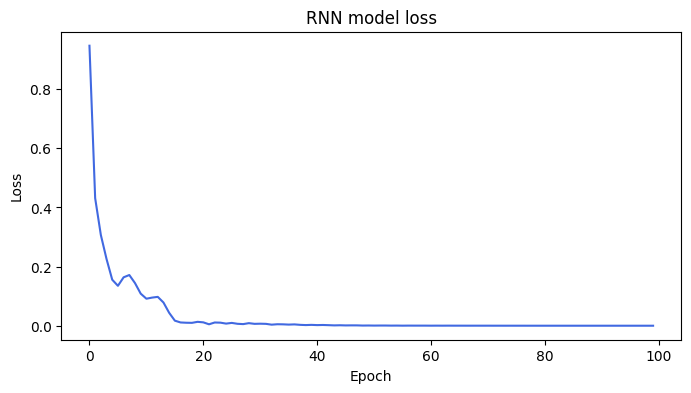

In [ ]:
#Training loss for RNN model
rcParams['figure.figsize'] = 8,4
rnn_loss_fig = sns.lineplot(data = train_hist_rnn, color = 'royalblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RNN model loss")
plt.show(rnn_loss_fig);